# Estabilidade

Quando fazemos um modelo, é muito importante avaliar se as variáveis que estamos utilizando são estáveis. Se tivermos uma base com medidas no tempo, podemos avaliar:

1. se as distribuições das variáveis explicativas são estáveis no tempo e
2. se as médias da variável resposta são estáveis no tempo por grupos de explicativas.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Fixing random state for reproducibility
np.random.seed(2360873)

In [7]:
tips = sns.load_dataset("tips")
tips['tip_pct'] = tips['tip'] / (tips['total_bill'] - tips['tip'])
tips.head()

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.063204
1,10.34,1.66,Male,No,Sun,Dinner,3,0.191244
2,21.01,3.50,Male,No,Sun,Dinner,3,0.199886
3,23.68,3.31,Male,No,Sun,Dinner,2,0.162494
4,24.59,3.61,Female,No,Sun,Dinner,4,0.172069


In [3]:
tips.shape

(244, 8)

####  Preparação da base de dados

Vamos fazer uma reamostragem da base de gorjetas para simular que essa base tenha medidas em três meses distintos, para podermos comparar as distribuições das variáveis no tempo.

In [17]:
n_meses = 3
n_clientes = 210

datas = pd.Series(pd.date_range('1/1/2019', periods = n_meses, freq = 'MS').repeat(n_clientes))

dados = tips.sample(n = n_meses * n_clientes, replace=True).reset_index()

tips2 = pd.concat([datas, dados], axis = 1)
tips2.rename({0:'data_ref'}, inplace = True, axis = 'columns')
tips2

,data_ref,index,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,2019-01-01,43,9.68,1.32,Male,No,Sun,Dinner,2,0.157895
1,2019-01-01,243,18.78,3.00,Female,No,Thur,Dinner,2,0.190114
2,2019-01-01,75,10.51,1.25,Male,No,Sat,Dinner,2,0.134989
3,2019-01-01,76,17.92,3.08,Male,Yes,Sat,Dinner,2,0.207547
4,2019-01-01,110,14.00,3.00,Male,No,Sat,Dinner,2,0.272727
...,...,...,...,...,...,...,...,...,...,...
625,2019-03-01,212,48.33,9.00,Male,No,Sat,Dinner,4,0.228833
626,2019-03-01,7,26.88,3.12,Male,No,Sun,Dinner,4,0.131313
627,2019-03-01,119,24.08,2.92,Female,No,Thur,Lunch,4,0.137996
628,2019-03-01,130,19.08,1.50,Male,No,Thur,Lunch,2,0.085324


In [19]:
tips2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   data_ref    630 non-null    datetime64[ns]
 1   index       630 non-null    int64         
 2   total_bill  630 non-null    float64       
 3   tip         630 non-null    float64       
 4   sex         630 non-null    category      
 5   smoker      630 non-null    category      
 6   day         630 non-null    category      
 7   time        630 non-null    category      
 8   size        630 non-null    int64         
 9   tip_pct     630 non-null    float64       
dtypes: category(4), datetime64[ns](1), float64(3), int64(2)
memory usage: 32.7 KB


#### Avaliação da distribuição

A distribuição das variáveis explicativas pode ser avaliada via gráfico de barras. Se uma variável tem sua distribuição alterada subitamente, é importante entender o fenômeno. Uma pandemia por exemplo pode alterar significativamente a distribuição de diversas variáveis, nesse caso, deve-se estudar tais variáveis para avaliar se o modelo continua funcionando.

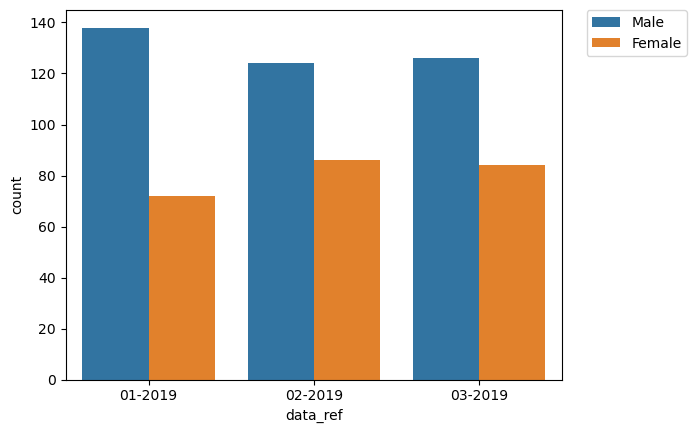

In [29]:
ax = sns.countplot(x='data_ref',  hue = 'sex', data=tips2)

tick_labs = tips2['data_ref'].map(lambda ts: ts.strftime("%m-%Y")).unique()

tick_labs.tolist()

ticks = ax.set_xticks(list(range(tips2['data_ref'].nunique())))
labels = ax.set_xticklabels(tick_labs, rotation=0)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### Barras empilhadas

Especialistas sugerem que barras não empilhadas sejam melhores para comparar distribuições, mas barras empilhadas podem ser uma opção estética para um painel.

In [7]:
tab = pd.crosstab(tips2['data_ref'],tips2['sex'])
tab.div(tab.sum(axis = 1), axis = 0)

sex,Male,Female
data_ref,,
2019-01-01,0.719048,0.280952
2019-02-01,0.652381,0.347619
2019-03-01,0.666667,0.333333


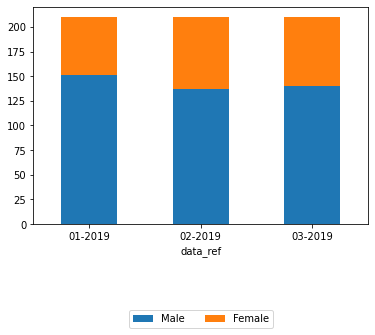

In [9]:
tab_freq = pd.crosstab(tips2['data_ref'],tips2['sex'])
tab = tab_freq.div(tab.sum(axis = 1), axis = 0)

ax = tab.plot.bar(stacked = True)

tick_labs = tips2['data_ref'].map(lambda ts: ts.strftime("%m-%Y")).unique()

ticks = ax.set_xticks(list(range(tips2['data_ref'].nunique())))
labels = ax.set_xticklabels(tick_labs, rotation=0)

plt.legend(loc = 'lower center', bbox_to_anchor=(0.5, -.50),ncol = 3)

#### Perfis médios no tempo

Essa informação é crucial para avaliar a qualidade de um modelo e sua estabilidade. Instabilidade nas médias da variável resposta para perfís específicos é um sinal crítico de alerta para a qualidade de um modelo que considere tais perfís.

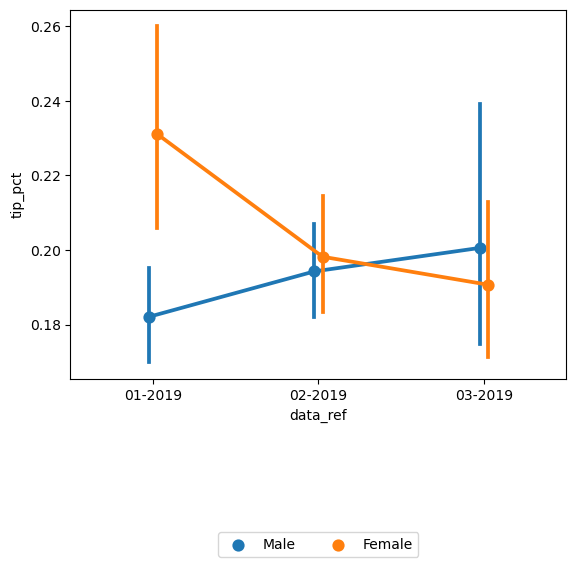

In [33]:
ax = sns.pointplot(x="data_ref", y="tip_pct", hue = 'sex',
                   data=tips2, dodge=True, errorbar=('ci', 95))

plt.legend(loc = 'lower center', bbox_to_anchor=(0.5, -.30),ncol = 3)

tick_labs = tips2['data_ref'].map(lambda ts: ts.strftime("%m-%Y")).unique()

ticks = ax.set_xticks(list(range(tips2['data_ref'].nunique())))
labels = ax.set_xticklabels(tick_labs, rotation=0)

plt.legend(loc = 'lower center', bbox_to_anchor=(0.5, -.50),ncol = 3)